Origin : http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html   
Translator : Hongpu Liu

In [2]:
%matplotlib inline
from __future__ import print_function

# 训练一个分类器
之前已经看到如何定义神经网络、计算损失以及更新网络的权重。

## 1. 数据（Data）
通常情况下，你可以使用标准的Python包来处理图像、文本、音频或视频数据，并将他们加载到NumPy数组中。然后再将这个数组转换为**torch.*Tensor**

- 对于图像数据，诸如Pillow、OpenCV非常有用
- 对于音频数据，可以使用SciPy和Librosa
- 对于文本，或者用基于原生Python/Cython进行加载，或者用NLTK或SpaCy来处理

对于视觉，**torchvision**提供了通用数据集（ImageNet、CIFAR-10、MNIST等）的加载器、图像数据变换器、可视化等功能。包括**torchvision.datasets**和**torch.utils.data.Dataloader**。

这个工具提供了巨大的便利，以避免书写千篇一律的载入代码。

下面的例子将使用CIFAR-10数据集。该数据包含以下10个类：
>  ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck'  

CIFAR-10中的图像尺寸为3*32*32，即3通道的32x32像素的图像。

![](./imgs/cifar10.png)

## 2. 训练一个图像分类器
通过以下步骤来实现图像分类器：
1. 使用**torchvision**加载并归一化的CIFAR-10的训练集和测试集
2. 定义一个卷积神经网络
3. 定义损失函数
4. 用训练集数据训练网络
5. 用测试集数据测试网络性能

### 2.1 加载和归一化CIFAR-10数据集
使用**torchvision**可以非常简单的载入CIFAR-10数据集。

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

**Torchvision**数据集的输出的图像是值在[0,1]之间的**PILImage**图像。将它们变换为像素值在[-1, 1]之间的归一化张量。

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


下面展示一些训练图像

truck  deer horse  frog


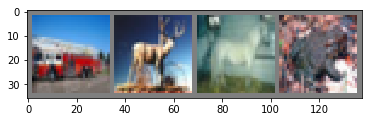

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 显示图像的函数
def imshow(img):
    img = img / 2 + 0.5 #从归一化中恢复
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# 随机获得一些训练图像
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图像
imshow(torchvision.utils.make_grid(images))
# 打印图像
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2.2 定义一个卷积神经网络
拷贝上一节的神经网络，将其输入改为三个通道（原始为1个通道）。

In [6]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x= x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 2.3 定义损失函数和优化器
使用分类交叉熵（Cross-Entropy）损失和带冲量的SGD优化器：

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 2.4 训练网络
从这里开始变得有趣起来。简单的利用数据迭代器获得输入，然后将输入送入到网络和优化器。

In [8]:
for epoch in range(4):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获得输入
        inputs, labels = data
        
        # 将输入和标签包裹到Variable中
        inputs, labels = Variable(inputs), Variable(labels)
        
        # 将梯度缓存清零
        optimizer.zero_grad()
        
        # 前馈、反馈和优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 打印状态
        running_loss += loss.data[0]
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 2.261
[1,  4000] loss: 1.929
[1,  6000] loss: 1.711
[1,  8000] loss: 1.613
[1, 10000] loss: 1.544
[1, 12000] loss: 1.493
[2,  2000] loss: 1.409
[2,  4000] loss: 1.379
[2,  6000] loss: 1.362
[2,  8000] loss: 1.344
[2, 10000] loss: 1.308
[2, 12000] loss: 1.280
[3,  2000] loss: 1.215
[3,  4000] loss: 1.205
[3,  6000] loss: 1.199
[3,  8000] loss: 1.199
[3, 10000] loss: 1.180
[3, 12000] loss: 1.181
[4,  2000] loss: 1.093
[4,  4000] loss: 1.114
[4,  6000] loss: 1.109
[4,  8000] loss: 1.092
[4, 10000] loss: 1.094
[4, 12000] loss: 1.098
Finished Training


### 2.5 用测试数据测试网络
前面已经用训练集对网络进行了两轮训练。接下来要检查网络是否学到了一些东西。

将网络输出的预测标签与基准数据标签进行比较，如果预测正确，将样本加入到预测正确的列表中。

首先，显示一些测试集图像。

GroundTruth:    cat horse  frog  frog


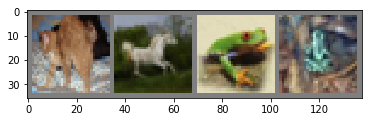

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 显示图像
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',' '.join('%5s' % classes[labels[j]] for j in range(4)))

接下来，用神经网络计算这些图像的标签：

In [10]:
outputs = net(Variable(images))

输出对应了10个分类的能量值。对应某个分类的能量值越高，神经网络对图像属于该分类的信心越强。因此，获得最高能量值的索引：

In [11]:
_, predicted = torch.max(outputs.data,1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   frog horse  frog truck


下面看一下在整个数据集中网络的性能。

In [12]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %


结果要比随机选择好，因为随机选择的话准确率只有10%（从10个类中随机选择一个）。看上去网络学到了一些东西。

计算哪些类上的性能较好，那些类效果不好：

In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 79 %
Accuracy of  bird : 46 %
Accuracy of   cat : 32 %
Accuracy of  deer : 53 %
Accuracy of   dog : 62 %
Accuracy of  frog : 62 %
Accuracy of horse : 67 %
Accuracy of  ship : 69 %
Accuracy of truck : 66 %


接下来讨论如何在GPU上运行神经网络。

## 3. 在GPU上训练
将神经网络迁移到GPU与将Tensor迁移GPU上类似。下面的语句将递归的将所有模块的参数和梯度缓存转换为GPU张量。

``` Python
net.cuda()
```

此外，还要记得将每步迭代的输入与目标转换为GPU张量：

``` Python
inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

在GPU上运行时，并没有巨大的速度提升。这是因为这个网络真的非常小。

**练习**尝试增加网络的宽度（第一个**nn.Conv2d**的第二个参数，和第二个**nn.Conv2d**的第一个参数，他们需要相同，即增加第一个卷积层的输出通道数），可以看看速度上的变化。

**目标达成**  
- 理解PyTorch的张量库和神经网络
- 训练一个用于分类图像的小型神经网络

## 4. 在多个GPU上进行训练
如果要获得更大的速度提升，可以阅读[数据并行](http://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)。